In [1]:
import H_mag_funcs
import os
from astroquery.mpc import MPC
from pprint import pprint
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

In [9]:
def non_Gaussian_plots(df_all_observ, sheet_name, file_dir, which_method = "HG"):
    print ("Analyzing the {} observatory".format(sheet_name))
    ################### SAVE FILE NAME #####################################
    save_name = "{}_Non-Gaussian_{}".format(sheet_name, which_method)

    df = df_all_observ[sheet_name]
    df = df.dropna()

    all_data = np.vstack(np.array(df))
    print (all_data.shape)
    if which_method == "HG":
        data = np.array(all_data[:,0])
    if which_method == "HG1G2":
        data = np.array(all_data[:,1])
    # Calculate mean and standard deviation
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)


    # Filter data to keep only values within 3 sigma from the mean
    data = data[np.abs(data - mean) <= 3 * std_dev]
    
    # Create KDE plot (smooth histogram)
    sns.kdeplot(data, color="orange", fill=True, alpha=0.5)
    
    # Define the 68% confidence interval
    conf_interval = (mean - std_dev, mean + std_dev)
    
    # Shade the 68% confidence region (dark orange)
    x_fill = np.linspace(conf_interval[0], conf_interval[1], 500)
    sns.kdeplot(data, fill=True, color="darkorange", alpha=0.8, clip=conf_interval, label="68% Confidence Interval")
    
    # Add a vertical line for the mean
    plt.axvline(mean, color='black', linestyle='dashed', label=f"Mean={mean:.3f}")
    
    # Labels and legend
    plt.xlabel("Bias (V - X)")
    plt.ylabel("Density")
    plt.title("{} observatory: Non-gaussian bias distribution".format(sheet_name))
    plt.legend()
    #plt.grid()
    plt.savefig(file_dir + save_name)
    # Show plot
    plt.show()
    
    # Print results
    print(f"Mean: {mean:.3f}")
    print(f"Standard Deviation: {std_dev:.3f}")
    print(f"68% Confidence Interval: {conf_interval}")


In [10]:
excel_list = np.array(os.listdir(r"C:\Users\nagai\Documents\Asteroids_BF_2\AstBFT08oj\T08oBF"))
print ("Number of files: ", len(excel_list))

Number of files:  117


# Obtaining the names of the asteroids from the excel sheet
### Correction for the last two

In [11]:
aster_names = [excel_name.split("-")[0] for excel_name in excel_list]
print (aster_names)
aster_names[-1] = '4239'
aster_names[-2] = '3719'
aster_names = np.array([int(asters) for asters in aster_names])
print (aster_names)

['100012', '110561', '1205', '13628', '14001', '1769', '1779', '1818', '1942', '1944', '1951', '1963', '1964', '2018', '2035', '2076', '2128', '2131', '2134', '2143', '2150', '2174', '2318', '2335', '2350', '2367', '2392', '2435', '247925', '2488', '2607', '2614', '2680', '2817', '2821', '2838', '2899', '2949', '2968', '2971', '3006', '3038', '30512', '3081', '3083', '30968', '3098', '3137', '31446', '3172', '3173', '3175', '3185', '3206', '3216', '3217', '3239', '3336', '3338', '3340', '3350', '3381', '3384', '3392', '3400', '3427', '3459', '3462', '3473', '3520', '3529', '3535', '3538', '3567', '3574', '3579', '3593', '3612', '3619', '3636', '3652', '3654', '3681', '3716', '3719', '3740', '3745', '3770', '3777', '3798', '3807', '3826', '3858', '3891', '3927', '3943', '3954', '3969', '3972', '4001', '4016', '40256', '4032', '4048', '4062', '4109', '4129', '4216', '4229', '4239', '4245', '4267', '64577', '74510', '90872', '~$3719', '~$4239']
[100012 110561   1205  13628  14001   1769  

# Choosing the best observatories

In [12]:
df = pd.read_excel(r"C:\Users\nagai\Documents\Asteroids_BF_2\AstBFT08oj\1205-4267.xlsx")

In [13]:
Asteroid_list_df = df["Aster."]

In [14]:
All_obs = df.iloc[:, 1::2]

All_obs_cleaned = All_obs.iloc[:, :-1]
obj_names = All_obs_cleaned.columns
print (obj_names)

Index(['T08o', '703G', '703V', 'C57G', 'D29R', 'F51w', 'G45r', 'P07G', 'G96G',
       'G96V', 'I41r', 'M22o', 'T05c', 'T05o', 'T08c', 'W68o', 'I41g', 'T05w',
       'Citi  '],
      dtype='object')


In [15]:
def selecting_asteroids(obs_name):
    temp_obs = df[obs_name]
    
    # Keep only strings ending with "+"
    filtered_temp_obs = temp_obs[temp_obs.map(lambda x: isinstance(x, str) and x.endswith('+'))]

    # Get indices of strings ending with "+"
    indices = filtered_temp_obs.index
    print (indices)
    
    Asteroids_excel = np.array(Asteroid_list_df[indices])

    # keeping only the asteroids that match
    idx_keep = np.where(np.isin(aster_names, Asteroids_excel))[0]
    return idx_keep

## For a list of asteroids

In [17]:
# Input parameters
path = r"C:\Users\nagai\Documents\Asteroids_BF_2\AstBFT08oj\T08oBF\\"
sheet_name = "T08o"
contamination = 0.02
outlier_removing = False
plot_bool = False

# creating the saving dictionary
all_data_dic = {}

for sheet_name in obj_names:
    print ("Observatory analyzed:", sheet_name)
    idx_for_excel = selecting_asteroids(sheet_name)
    excel_list_for_obs = excel_list[idx_for_excel]
    # Running the code
    H_dis_list = []
    for excel_name in tqdm(excel_list_for_obs):
        try:
            asteroid_numb = excel_name.split("-")[0]
            if asteroid_numb == "~$3719":
                asteroid_numb = "3719"
            if asteroid_numb == "~$4239":
                asteroid_numb = "4239"
            result = MPC.query_object('asteroid', number = asteroid_numb)
            H_MPC = float(result[0]['absolute_magnitude'])
            # saves the HG and HG1G2 displacement
            H_displacement = H_mag_funcs.main(path, excel_name, asteroid_numb, H_MPC, contamination = 0.02, outlier_removing= outlier_removing, plot_bool = plot_bool, sheet_name = sheet_name)
            H_dis_list.append(H_displacement)
        except Exception as e:
            print(f"Asteroid number causing error: {asteroid_numb}, Error: {e}")


    all_data_dic[sheet_name] = H_dis_list

#df_all_obs = pd.DataFrame.from_dict(all_data_dic)



Observatory analyzed: T08o
Index([ 0,  1,  2,  4,  6,  7,  8, 14, 16, 18, 19, 20, 21, 22, 23, 24, 26, 27,
       29, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 49, 50,
       53, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 72, 73, 74, 76,
       77, 78, 81, 82, 83, 84, 85, 87, 88, 90, 91, 92, 95, 97],
      dtype='int64')


 19%|███████████████▋                                                                  | 13/68 [00:58<02:36,  2.84s/it]

Asteroid number causing error: 2607, Error: 'epoch'


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [04:56<00:00,  4.36s/it]


Asteroid number causing error: 3719, Error: Excel file format cannot be determined, you must specify an engine manually.
Observatory analyzed: 703G
Index([ 0,  1,  2,  4,  7,  9, 10, 11, 13, 14, 16, 20, 21, 22, 23, 24, 26, 27,
       30, 36, 37, 38, 40, 41, 43, 44, 45, 46, 47, 49, 50, 53, 56, 58, 59, 60,
       61, 64, 65, 66, 67, 68, 72, 73, 74, 75, 76, 77, 78, 82, 83, 85, 86, 88,
       90, 91, 92, 94, 95, 97],
      dtype='int64')


 90%|█████████████████████████████████████████████████████████████████████████▉        | 55/61 [03:17<00:14,  2.42s/it]

Asteroid number causing error: 4048, Error: 'magred'


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [03:32<00:00,  3.49s/it]


Asteroid number causing error: 3719, Error: Excel file format cannot be determined, you must specify an engine manually.
Observatory analyzed: 703V
Index([ 4, 13, 16, 20, 21, 23, 26, 27, 31, 35, 37, 40, 41, 42, 47, 50, 53, 56,
       57, 58, 59, 60, 61, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77,
       78, 82, 83, 84, 85, 86, 88, 91, 92, 95, 98],
      dtype='int64')


C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 2.95s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 2.78s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [02:31<00:00,  3.22s/it]


Asteroid number causing error: 3719, Error: Excel file format cannot be determined, you must specify an engine manually.
Observatory analyzed: C57G
Index([15, 22, 26, 30, 32, 41, 42, 51, 54, 65, 68, 69, 70, 74, 98], dtype='int64')


C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10<?, ?it/s]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
  7%|█████▌                                                                             | 1/15 [00:00<00:13,  1.02it/s]

Asteroid number causing error: 2335, Error: index -1 is out of bounds for axis 0 with size 0


C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 5.17s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
 33%|███████████████████████████▋                                                       | 5/15 [00:16<00:27,  2.74s/it]

Asteroid number causing error: 3038, Error: Worksheet named 'C57G' not found


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:01<00:00,  4.08s/it]


Observatory analyzed: D29R
Index([ 1,  2,  7,  8, 17, 21, 23, 24, 26, 27, 31, 41, 45, 46, 47, 49, 50, 56,
       60, 64, 65, 68, 69, 72, 73, 74, 75, 77, 78, 81, 83, 85, 86, 88, 92, 95,
       96],
      dtype='int64')


C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 4.33s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 3.57s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 2.98s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 3.25s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
 31%|█████████████████████████▏                                                        | 12/39 [00:39<01:34,  3.49s/it]

Asteroid number causing error: 3336, Error: Worksheet named 'D29R' not found


C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 2.69s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 2.81s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 2.57s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 3.12s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 2.64s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 2.75s/it]
  V = H - 2.5 * np.l

Asteroid number causing error: 3719, Error: Excel file format cannot be determined, you must specify an engine manually.
Asteroid number causing error: 4239, Error: Excel file format cannot be determined, you must specify an engine manually.
Observatory analyzed: F51w
Index([ 0,  1,  4,  7,  8, 16, 17, 19, 20, 21, 23, 24, 26, 29, 35, 37, 40, 41,
       42, 50, 54, 58, 60, 64, 65, 66, 68, 72, 73, 74, 75, 76, 78, 81, 82, 85,
       86, 87, 88, 91, 92, 93, 94, 98, 99],
      dtype='int64')


C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 8.54s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 4.64s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 4.51s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
 24%|███████████████████▌                                                              | 11/46 [00:40<01:24,  2.41s/it]

Asteroid number causing error: 2680, Error: Worksheet named 'F51w' not found


C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 4.91s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 4.25s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
 52%|██████████████████████████████████████████▊                                       | 24/46 [01:29<00:58,  2.66s/it]

Asteroid number causing error: 3538, Error: Worksheet named 'F51w' not found


C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 3.69s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 4.07s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:56<00:00,  3.83s/it]


Asteroid number causing error: 3719, Error: Excel file format cannot be determined, you must specify an engine manually.
Observatory analyzed: G45r
Index([ 8, 13, 16, 27, 28, 29, 31, 32, 35, 37, 45, 47, 50, 56, 59, 61, 64, 65,
       69, 71, 73, 76, 78, 83, 84, 85, 86, 87, 88, 94],
      dtype='int64')


C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10<?, ?it/s]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 7.70s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 5.40s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 3.81s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
 31%|█████████████████████████▊                                                         | 9/29 [00:35<00:46,  2.31s/it]

Asteroid number causing error: 3098, Error: Worksheet named 'G45r' not found


 38%|███████████████████████████████                                                   | 11/29 [00:41<00:42,  2.34s/it]

Asteroid number causing error: 3336, Error: Worksheet named 'G45r' not found


 97%|███████████████████████████████████████████████████████████████████████████████▏  | 28/29 [01:56<00:02,  2.83s/it]

Asteroid number causing error: 4016, Error: Worksheet named 'G45r' not found


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [01:59<00:00,  4.13s/it]


Observatory analyzed: P07G
Index([24, 27, 35, 40, 49, 50, 58, 66, 67, 68, 74, 78, 82, 85, 86], dtype='int64')


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:15<00:00,  5.02s/it]


Observatory analyzed: G96G
Index([  0,   1,   2,   3,   8,  13,  14,  16,  19,  20,  21,  22,  23,  24,
        26,  27,  29,  34,  35,  36,  40,  41,  42,  43,  44,  45,  46,  47,
        49,  50,  53,  54,  56,  57,  58,  59,  60,  61,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  78,  80,  81,  82,  84,  85,
        86,  87,  88,  90,  92,  94,  95,  97,  98, 100],
      dtype='int64')


C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 7.81s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 5.87s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 5.72s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 5.80s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 4.05s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 3.93s/it]
  V = H - 2.5 * np.l

Asteroid number causing error: 3459, Error: 'Ph'


C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 4.71s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
 67%|██████████████████████████████████████████████████████▋                           | 44/66 [03:08<01:09,  3.15s/it]

Asteroid number causing error: 3654, Error: Worksheet named 'G96G' not found


C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 2.59s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 2.21s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [04:38<00:00,  4.22s/it]


Asteroid number causing error: 3719, Error: Excel file format cannot be determined, you must specify an engine manually.
Observatory analyzed: G96V
Index([21, 23, 24, 32, 34, 35, 36, 40, 42, 50, 56, 58, 59, 64, 66, 67, 68, 71,
       72, 73, 75, 76, 77, 80, 81, 82, 85, 88, 94, 97],
      dtype='int64')


C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 3.42s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 3.34s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 3.16s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 2.96s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 2.90s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [01:36<00:00,  3.12s/it]


Asteroid number causing error: 3719, Error: Excel file format cannot be determined, you must specify an engine manually.
Observatory analyzed: I41r
Index([ 0,  2,  3, 10, 19, 20, 22, 27, 40, 42, 44, 47, 53, 56, 64, 65, 75, 76,
       78, 81, 84, 88, 92],
      dtype='int64')


C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 5.55s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
 18%|███████████████                                                                    | 4/22 [00:11<00:38,  2.13s/it]

Asteroid number causing error: 2035, Error: Worksheet named 'I41r' not found


C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 3.68s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:22<00:00,  3.76s/it]


Observatory analyzed: M22o
Index([19, 23, 40, 46, 50, 56, 65, 69, 71, 74, 77, 83, 90, 91, 100], dtype='int64')


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:00<00:00,  4.03s/it]


Observatory analyzed: T05c
Index([ 1,  4,  7,  8, 13, 14, 16, 19, 20, 21, 22, 23, 24, 26, 27, 34, 35, 36,
       38, 40, 41, 43, 44, 45, 46, 47, 49, 50, 54, 56, 57, 58, 59, 60, 61, 64,
       65, 66, 68, 69, 71, 72, 73, 74, 76, 77, 78, 81, 82, 84, 85, 86, 87, 88,
       92, 94, 95, 97, 98],
      dtype='int64')


C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 3.36s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 4.97s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
 64%|████████████████████████████████████████████████████▊                             | 38/59 [02:14<01:09,  3.29s/it]

Asteroid number causing error: 3619, Error: 'Ph'


C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 4.44s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 3.72s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [03:31<00:00,  3.58s/it]


Asteroid number causing error: 3719, Error: Excel file format cannot be determined, you must specify an engine manually.
Observatory analyzed: T05o
Index([ 0,  1,  2,  3,  4,  7,  8,  9, 14, 16, 19, 20, 21, 22, 23, 24, 26, 27,
       29, 30, 31, 34, 35, 36, 37, 41, 46, 47, 49, 50, 53, 54, 56, 59, 60, 61,
       63, 64, 65, 66, 68, 69, 71, 72, 73, 74, 76, 77, 78, 80, 81, 82, 83, 84,
       86, 88, 91, 92, 94, 95, 97, 98, 99],
      dtype='int64')


C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 4.89s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [04:34<00:00,  4.35s/it]


Asteroid number causing error: 3719, Error: Excel file format cannot be determined, you must specify an engine manually.
Observatory analyzed: T08c
Index([7, 24, 27, 36, 49, 78, 80, 83, 93, 99], dtype='int64')


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.42s/it]


Asteroid number causing error: 4129, Error: Worksheet named 'T08c' not found
Observatory analyzed: W68o
Index([  0,   1,   4,  13,  16,  19,  20,  22,  23,  34,  35,  40,  46,  49,
        50,  54,  56,  58,  61,  64,  65,  66,  67,  68,  69,  72,  74,  75,
        76,  77,  78,  81,  82,  83,  84,  85,  86,  88,  91,  92,  97,  98,
       100],
      dtype='int64')


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [03:02<00:00,  4.25s/it]


Asteroid number causing error: 3719, Error: Excel file format cannot be determined, you must specify an engine manually.
Observatory analyzed: I41g
Index([2, 4, 5, 22], dtype='int64')


C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 6.40s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 4.20s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:10<00:02,  2.83s/it]

Asteroid number causing error: 1951, Error: index -1 is out of bounds for axis 0 with size 0


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.08s/it]


Observatory analyzed: T05w
Index([27, 65, 77, 80, 83], dtype='int64')


C:\Users\nagai\Documents\Asteroid work\H_mag_funcs.py:210: RuntimeWarning: invalid value encountered in log10 2.37s/it]
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.47s/it]


Observatory analyzed: Citi  
Index([7, 19, 65, 66, 68, 76, 78, 81], dtype='int64')


 25%|█████████████████████                                                               | 2/8 [00:00<00:01,  4.51it/s]

Asteroid number causing error: 1964, Error: Worksheet named 'Citi  ' not found
Asteroid number causing error: 2435, Error: Worksheet named 'Citi  ' not found


 50%|██████████████████████████████████████████                                          | 4/8 [00:00<00:00,  6.18it/s]

Asteroid number causing error: 3612, Error: Worksheet named 'Citi  ' not found
Asteroid number causing error: 3619, Error: Worksheet named 'Citi  ' not found


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:01<00:00,  6.85it/s]

Asteroid number causing error: 3652, Error: Worksheet named 'Citi  ' not found
Asteroid number causing error: 3777, Error: Worksheet named 'Citi  ' not found


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.08it/s]

Asteroid number causing error: 3807, Error: Worksheet named 'Citi  ' not found
Asteroid number causing error: 3891, Error: Worksheet named 'Citi  ' not found


In [18]:
df_all_obs = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in all_data_dic.items()]))


In [19]:
df_all_obs

,T08o,703G,703V,C57G,D29R,F51w,G45r,P07G,G96G,G96V,I41r,M22o,T05c,T05o,T08c,W68o,I41g,T05w,Citi
0,"[0.10079183995283802, 0.09804786769926022]","[0.12602353702165292, 0.12720768350095657]","[-0.23350301280994845, -0.24182412566481304]","[0.0931379635468721, 0.11139991863683907]","[0.11990256917589726, 0.12000740117548059]","[0.034769391234612534, 0.0541718025805249]","[0.32336290106974186, 0.32601682027174306]","[-0.09624103982317145, -0.08679336815244643]","[0.12145003195813686, 0.12061637340401177]","[-0.0939799246301769, -0.09389381971141386]","[-0.07042682045244852, -0.0708917896461605]","[-0.01936480415122155, -0.036020805200849715]","[0.011200813015873834, 0.006832243937664018]","[0.06830172479185315, 0.05921065878621068]","[0.1156312895183067, 0.11705534006298546]","[0.05147302324858494, 0.05287610515776553]","[-0.09476209304376493, -0.09655058985226095]","[0.1383565890876195, 0.1850271770532821]",NaN
1,"[-0.053276580934877416, -0.05399596202416035]","[-0.02212226689295349, -0.027777295864759743]","[-0.07819115161900392, -0.07471429967223475]","[0.24507545899316074, 0.2445868903426689]","[0.04026384491353685, 0.04608834202251]","[-0.08832973878114458, -0.09049718795176798]","[0.14670031669159833, 0.12861192247470932]","[0.02402571199539505, 0.029535625157423695]","[-0.004061440350096923, -0.007296369625144017]","[-0.12227255980788598, -0.12328064349954104]","[-0.28767900133891544, -0.28780815780931945]","[0.06640025197353339, 0.0658885248315304]","[-0.004714962734474248, -0.007799345685575609]","[-0.05182599556860712, -0.0509998572122754]","[-0.12858841769259222, -0.13395595362058277]","[-0.05804580609691623, -0.06081057735345219]","[0.0716954346482126, 0.08292511345898124]","[-0.05812819694009086, -0.02452047506701671]",NaN
2,"[-0.1240598318744155, -0.12333092729256823]","[-0.05747740883801011, -0.05823892835727751]","[-0.18052325734933738, -0.18532625785149381]","[-0.003959604032550246, -0.8391630748119798]","[0.6344065525839877, 0.6566558597884011]","[-0.2103889422329175, -0.20913840386362637]","[0.14548377140065671, 0.1416507577367323]","[3.247066918277142e-05, 0.00588315732026512]","[-0.14175681751452007, -0.14206606216145534]","[-0.3094169105373812, -0.31459816061171963]","[-0.10257955033694177, -0.126999521926642]","[-0.12299392089302597, -0.12841270613264033]","[-0.03612963069466257, -0.04037040633721123]","[-0.12807595303059305, -0.1275597218621929]","[0.07702418086940455, 0.07262459388618847]","[-0.03365525845690698, -0.02392863843936688]","[-0.13634667522999244, -0.14186391358991823]","[0.07538635971255303, 0.0009064105701224179]",NaN
3,"[-0.04211096884979337, -0.04141831604359236]","[-0.1496263903809858, -0.14176918448096565]","[-0.30014565504093227, -0.3019546802505202]","[0.05747174675581057, 0.06364610398198778]","[0.15117539500394983, 0.15118331729397028]","[-0.09840482158321251, -0.10443668867352685]","[0.2055512783483886, 0.2078415102632265]","[0.0727412769158855, 0.08706043575312261]","[-0.03656514716260517, -0.017452216556468336]","[-0.0434560004154223, -0.05052091926079427]","[-0.1569590680592956, -0.17185769380654126]","[0.03362435498248306, 0.041081089044521235]","[-0.02876695801239393, -0.025961039514329265]","[-0.04256991486275119, -0.03187358169217713]","[0.05569035448643156, 0.07210579610103718]","[-0.01235476435837235, -0.005230951822436047]",NaN,"[-0.26808352049938833, -0.2987514171306067]",NaN
4,"[0.08193010565137637, 0.0656168198163325]","[0.004193101135448352, 0.0032440864291887195]","[-0.13783359172903342, -0.14076924435466776]","[-0.15969381820793593, -0.18543939131105525]","[0.20911544447889607, 0.1558146793258519]","[-0.06559708564585343, -0.06485107824801162]","[-0.015521269449328301, -0.020649583367433166]","[0.17411958202485067, 0.14285363497005132]","[0.03942799430566346, 0.0477799107601351]","[0.04232436660029926, 0.033100056156845525]","[-0.35382060834585793, -0.36251106941104805]","[0.056861268308530555, 0.05097459446725239]","[0.029826869922100485, 0.02863284762075846]","[-0.05

In [20]:
with open('Obs_hg_hg1g2_plus_data_first_test.pkl'.format(sheet_name), 'wb') as file:
    pickle.dump(df_all_obs, file)

In [21]:


with open('Obs_hg_hg1g2_plus_data_first_test.pkl'.format(sheet_name), 'rb') as file:
    df_all_observ = pickle.load(file)

# Non-Gaussian representation

Analyzing the T08o observatory
(66, 2)


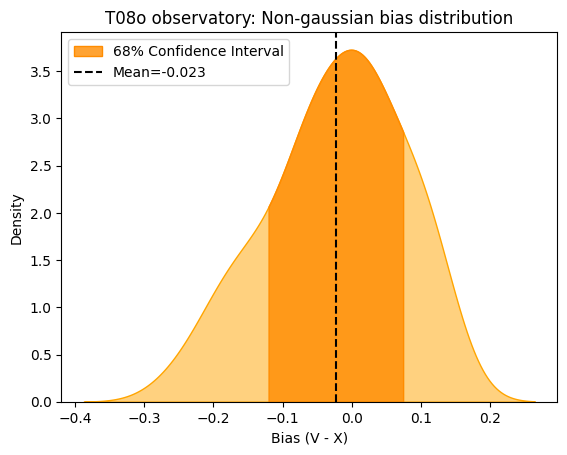

Mean: -0.023
Standard Deviation: 0.097
68% Confidence Interval: (-0.12009839430018514, 0.07429907265437148)
Analyzing the 703G observatory
(59, 2)


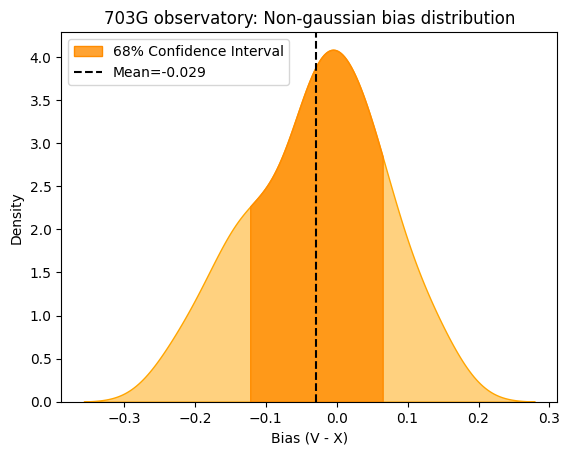

Mean: -0.029
Standard Deviation: 0.093
68% Confidence Interval: (-0.12190021728378639, 0.06477525858977998)
Analyzing the 703V observatory
(46, 2)


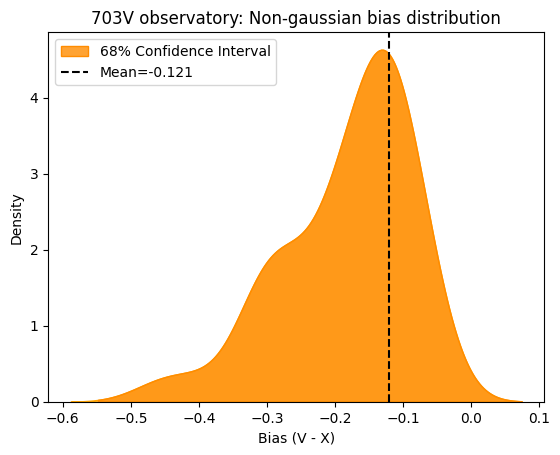

Mean: -0.121
Standard Deviation: 0.427
68% Confidence Interval: (-0.5482493256954455, 0.30641723460721615)
Analyzing the C57G observatory
(13, 2)


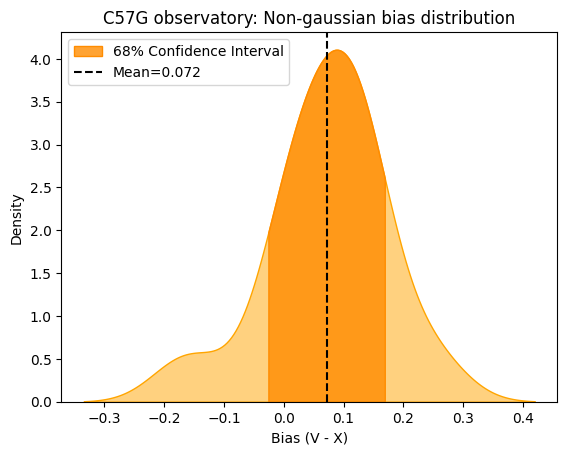

Mean: 0.072
Standard Deviation: 0.097
68% Confidence Interval: (-0.025702926576216284, 0.16893496233911215)
Analyzing the D29R observatory
(36, 2)


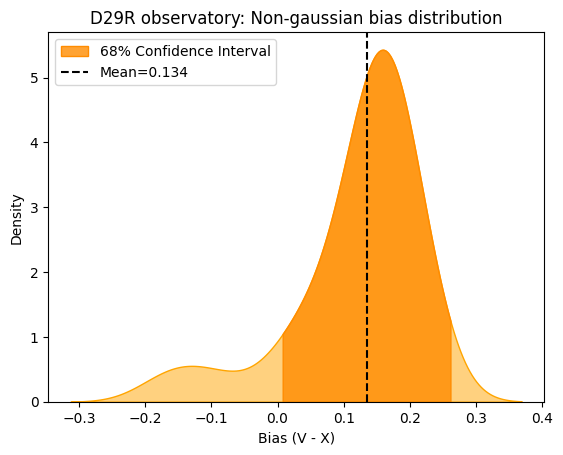

Mean: 0.134
Standard Deviation: 0.127
68% Confidence Interval: (0.007791283771889895, 0.26099391794058946)
Analyzing the F51w observatory
(43, 2)


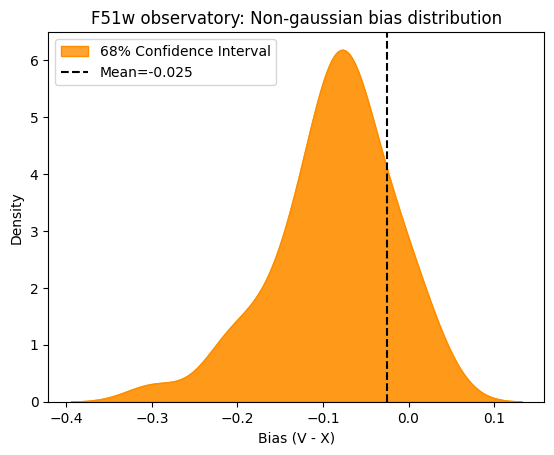

Mean: -0.025
Standard Deviation: 0.416
68% Confidence Interval: (-0.4404540387596217, 0.3905674465656836)
Analyzing the G45r observatory
(26, 2)


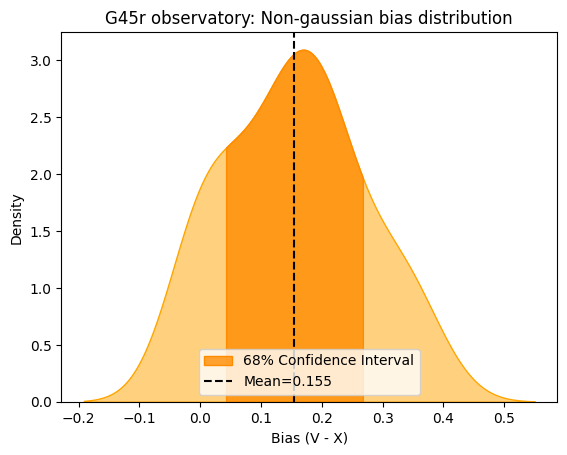

Mean: 0.155
Standard Deviation: 0.112
68% Confidence Interval: (0.04267119716357186, 0.26754743665807657)
Analyzing the P07G observatory
(15, 2)


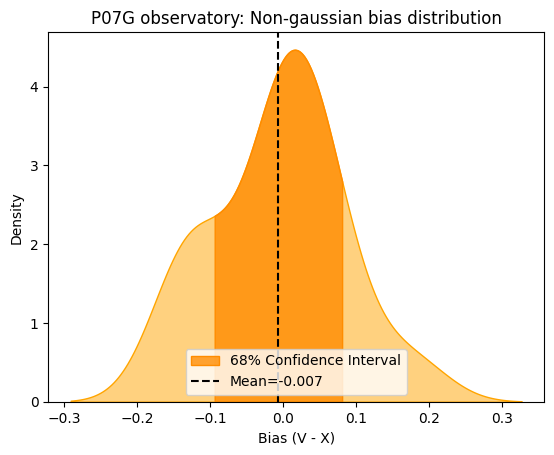

Mean: -0.007
Standard Deviation: 0.087
68% Confidence Interval: (-0.09381854189731667, 0.08060469340049176)
Analyzing the G96G observatory
(63, 2)


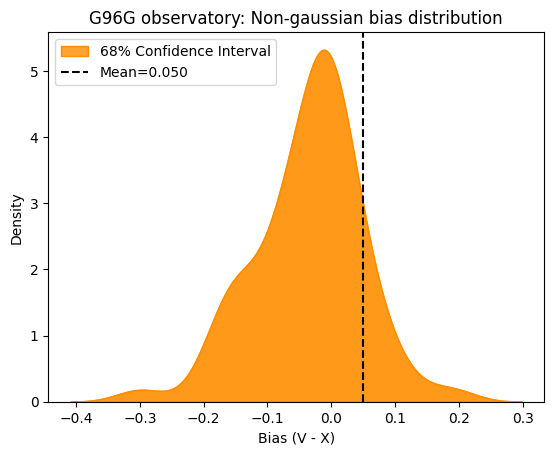

Mean: 0.050
Standard Deviation: 0.687
68% Confidence Interval: (-0.6362631657753379, 0.7368495795132073)
Analyzing the G96V observatory
(30, 2)


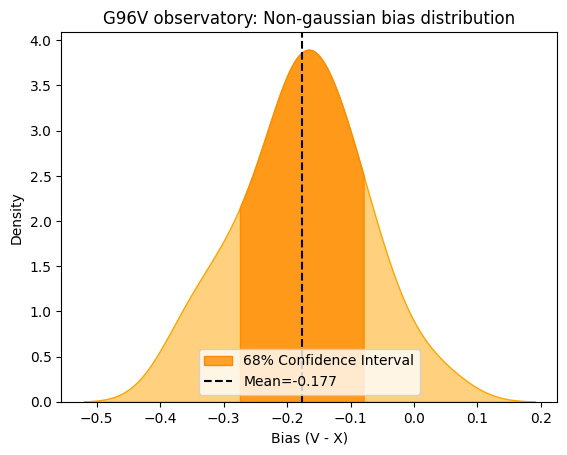

Mean: -0.177
Standard Deviation: 0.097
68% Confidence Interval: (-0.274101137766376, -0.07943713809213535)
Analyzing the I41r observatory
(21, 2)


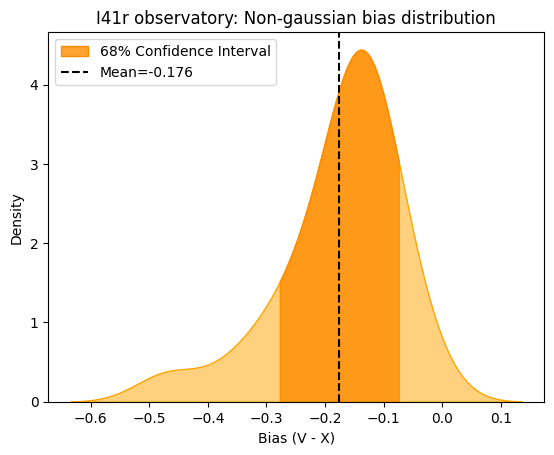

Mean: -0.176
Standard Deviation: 0.101
68% Confidence Interval: (-0.27720403492112444, -0.074239688568187)
Analyzing the M22o observatory
(15, 2)


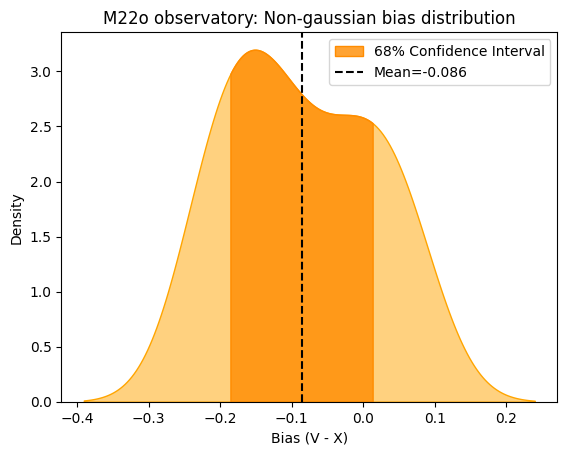

Mean: -0.086
Standard Deviation: 0.099
68% Confidence Interval: (-0.18551822375303698, 0.013220716138105076)
Analyzing the T05c observatory
(57, 2)


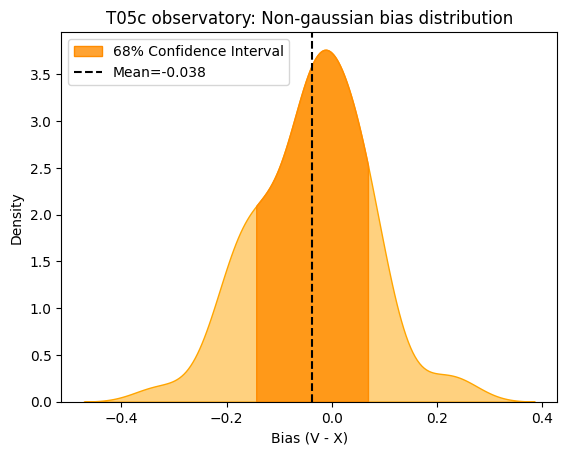

Mean: -0.038
Standard Deviation: 0.106
68% Confidence Interval: (-0.14376559902664923, 0.06861178869411097)
Analyzing the T05o observatory
(62, 2)


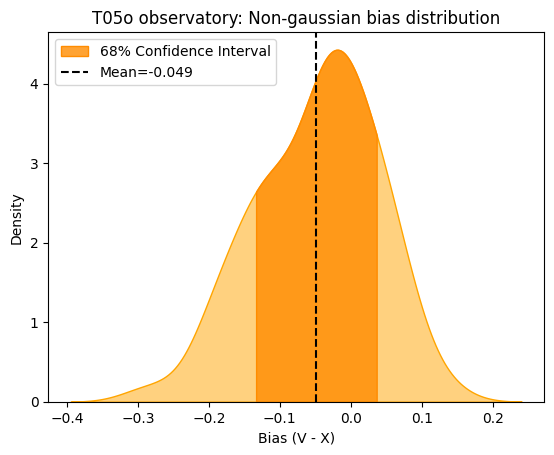

Mean: -0.049
Standard Deviation: 0.085
68% Confidence Interval: (-0.13344762543567756, 0.03644568300953153)
Analyzing the T08c observatory
(9, 2)


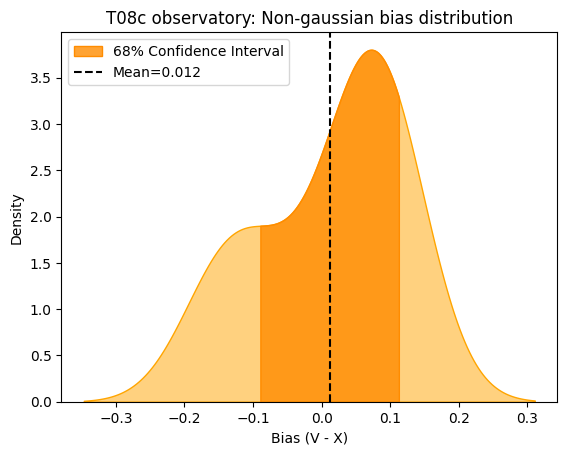

Mean: 0.012
Standard Deviation: 0.101
68% Confidence Interval: (-0.08925994138707569, 0.11261808450200617)
Analyzing the W68o observatory
(42, 2)


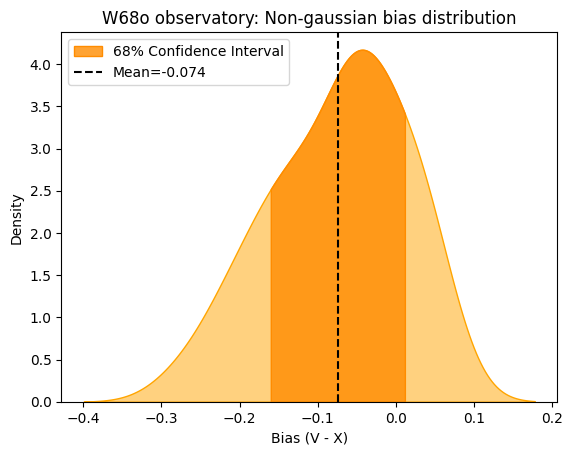

Mean: -0.074
Standard Deviation: 0.086
68% Confidence Interval: (-0.15995367451378853, 0.01163897987717788)
Analyzing the I41g observatory
(3, 2)


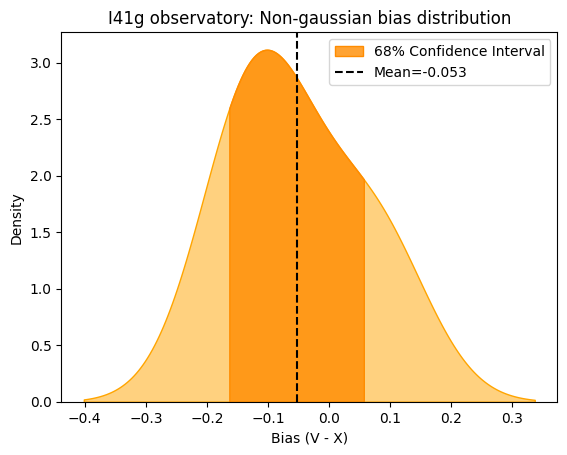

Mean: -0.053
Standard Deviation: 0.110
68% Confidence Interval: (-0.16322782093350705, 0.05695226518314386)
Analyzing the T05w observatory
(5, 2)


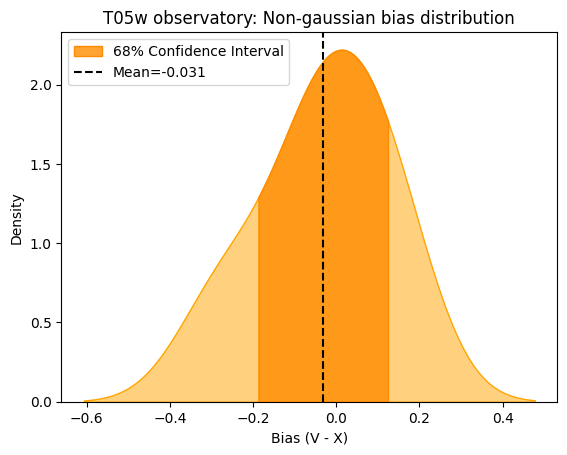

Mean: -0.031
Standard Deviation: 0.156
68% Confidence Interval: (-0.18717463036166415, 0.12446701894555495)


In [22]:
file_dir = r"C:\Users\nagai\Documents\Plots_for_asteroid_distribution\\"
which_method = "HG"

for sheet_name in obj_names[:-1]:
    non_Gaussian_plots(df_all_observ, sheet_name, file_dir, which_method = "HG")

# MISC

### For finding the matching asteroids with some databases

In [99]:
import re

def extract_asteroid_data(filename):
    asteroid_ids = []
    H_values = []
    G_values = []
    
    # Match asteroid ID in the first 29 characters (e.g., "(26760)")
    asteroid_id_re = re.compile(r'^\s*\((\d+)\)')
    
    # This regex looks for a closing bracket, then optional spaces,
    # then a magnitude system indicator (1–2 uppercase letters),
    # then H value, its error, G value, and its error.
    # In your sample, this matches: "] R  15.09 0.1   0.05 0.05"
    mag_re = re.compile(
        r'\]\s*([A-Z]{1,2})\s+([-+]?\d*\.\d+|\d+)\s+'
        r'([-+]?\d*\.\d+|\d+)\s+([-+]?\d*\.\d+|\d+)\s+'
        r'([-+]?\d*\.\d+|\d+)'
    )
    
    with open(filename, 'r') as f:
        for line in f:
            line = line.rstrip('\n')
            if not line.strip() or line.startswith("AsterId"):
                continue  # skip header and empty lines

            # Extract asteroid ID from the first 29 characters.
            id_match = asteroid_id_re.match(line[:29])
            if not id_match:
                continue
            asteroid_id = int(id_match.group(1))
            
            # Look for the magnitude fields after the closing bracket.
            mag_match = mag_re.search(line)
            if not mag_match:
                continue  # Skip if H and G are not provided.
            
            try:
                # According to our regex:
                # group(2) is H, group(4) is G.
                H_val = float(mag_match.group(2))
                G_val = float(mag_match.group(4))
            except ValueError:
                continue
            
            asteroid_ids.append(asteroid_id)
            H_values.append(H_val)
            G_values.append(G_val)
    
    return asteroid_ids, H_values, G_values

if __name__ == '__main__':
    filename = r'C:\Users\nagai\Documents\Asteroid work\Database\newres.txt'
    ids, H_list, G_list = extract_asteroid_data(filename)


In [97]:
asteroid_ids = []
for excel_name in excel_list:
    asteroid_numb = int(excel_name.split("-")[0])
    asteroid_ids.append(asteroid_numb)

In [98]:
[i for i in ids if i in asteroid_ids]

[1951, 2131]

In [101]:
len(H_list)

867

In [94]:
ids

[]

# Gaussian representation

In [14]:
# Needed for both Gaussian and Non-Gaussian

# Sample data: Replace this with your list of values

# 0 = HG method
# 1 = HG1G2 method
data = np.array(H_dis_list[:,1])

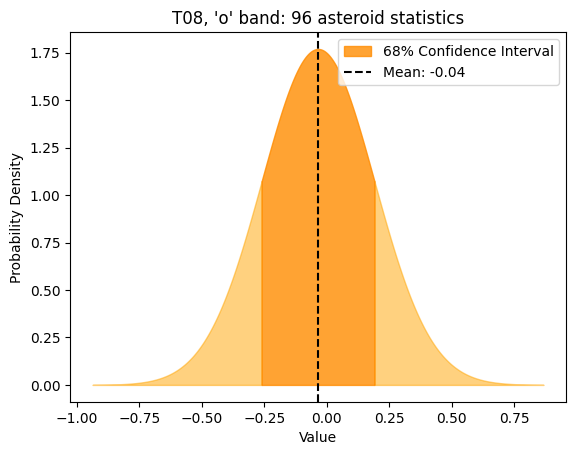

Mean: -0.035
Standard Deviation: 0.225
68% Confidence Interval: (-0.26043494944652595, 0.19028094918990274)


In [15]:
################### SAVE FILE NAME #####################################
save_name = "Gaussian_{}".format(sheet_name)

# Calculate mean and standard deviation
mean = np.mean(data)
std_dev = np.std(data, ddof=1)  # Using sample standard deviation (ddof=1)

# Generate Gaussian distribution
x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)
pdf = norm.pdf(x, mean, std_dev)

# Calculate 68% confidence interval
conf_interval = (mean - std_dev, mean + std_dev)


x_fill = np.linspace(conf_interval[0], conf_interval[1], 500)
pdf_fill = norm.pdf(x_fill, mean, std_dev)

# Fill the outer region (outside 68% confidence interval)
x_outer_left = np.linspace(mean - 4*std_dev, conf_interval[0], 500)
x_outer_right = np.linspace(conf_interval[1], mean + 4*std_dev, 500)
pdf_outer_left = norm.pdf(x_outer_left, mean, std_dev)
pdf_outer_right = norm.pdf(x_outer_right, mean, std_dev)

plt.fill_between(x_outer_left, pdf_outer_left, color="orange", alpha=0.5)
plt.fill_between(x_outer_right, pdf_outer_right, color="orange", alpha=0.5)

# Fill the 68% confidence interval (darker orange)
plt.fill_between(x_fill, pdf_fill, color="darkorange", alpha=0.8, label="68% Confidence Interval")

# Labels and legend
plt.xlabel("Value")
plt.ylabel("Probability Density")
plt.title("T08, 'o' band: 96 asteroid statistics")
plt.axvline(mean, color='black', linestyle='dashed', label=f"Mean: {mean:.2f}")

plt.legend()
plt.savefig(save_name)
# Show plot
plt.show()

# Print results
print(f"Mean: {mean:.3f}")
print(f"Standard Deviation: {std_dev:.3f}")
print(f"68% Confidence Interval: {conf_interval}")


In [57]:
((3.349466e-01 -2.968926e-01 ) - (3.299035e-01 - 3.016005e-01))/(3.349466e-01 -2.968926e-01 )

0.25624113102433277